# PR-001 GAN

유재준 님의 [GAN 강의](https://www.youtube.com/watch?v=L3hz57whyNw&list=PLlMkM4tgfjnJhhd4wn5aj8fVTYJwIpWkS&index=2) 감사드립니다.

이는 GAN을 이용하여 MNIST를 학습시키는 코드입니다.

논문: [https://arxiv.org/abs/1406.2661](https://arxiv.org/abs/1406.2661)

# Import Modules

In [1]:
from keras.datasets import mnist
from keras.layers import Input, Flatten, Dense, LeakyReLU, Reshape, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Dataset

MNIST 데이터는 별도의 다운로드 없이 keras에서 가져올 수 있습니다.

앞으로의 학습에는 train 데이터만 활용합니다.

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train shape:  (60000, 28, 28)
y_train shape:  (60000,)


5


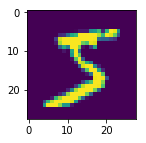

In [4]:
plt.figure(figsize=(2, 2))
plt.imshow(X_train[0])
print(y_train[0])

### preprocessing dataset

In [5]:
# 데이터를 학습에 적합한 float32 로 바꾸어 주고 255.0으로 나누어 Normalize 시킵니다.
X_train = X_train.astype('float32') / 255.0

# 학습 시 이미지 파일의 numpy 형태는 (batch_size, img_height, img_width, img_channel) 형태가 되어야 합니다.
# 흑백사진이라 가장 뒷 부분에 channel이 없군요. expand_dims 를 통해 만들어 줍니다.
X_train = np.expand_dims(X_train, axis=3)

print(X_train.shape)

(60000, 28, 28, 1)


# Build Model

모든 모델은 [keras functional api](https://keras.io/models/model/) 를 사용합니다.

복잡한 모델을 만들 때 유용하므로 아직 익숙하지 않으신 분들도 functional model을 자주 사용해보시길 권장드립니다.

### Discriminator

Discriminator(경찰) 모델은 입력된 이미지를 real_data 인지, generator 모델이 만들어 낸 데이터인지 구별해 냅니다.

mnist data의 형태가 (28, 28, 1)이였죠? 

input shape 또한 (28, 28, 1)로 만들어 줍니다.

간단합니다. 이미지를 Flatten 시킨 후 2 개의 Dense layer를 거쳐 하나의 output을 얻어 냅니다.

Discriminator는 이미지가 real data 라 판별하면 1, generator 모델이 만들어 낸 data 라 판별하면 0 으로 output을 갖도록 학습시킵니다.

In [6]:
img = Input(shape=(28, 28, 1))

x = Flatten()(img)
x = Dense(512)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(img, x)

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total para

항상 binary classification에 따라오는 sigmoid와 binary_crossentropy 입니다.

In [7]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

### Generator

Generator(위조지폐범) 모델은 discriminator(경찰) 모델이 알아채지 못하도록 이미지를 생성해 내야 합니다.

다만 input으로 100개의 uniform distribution을 따르는 random 값이 들어갑니다.

또한 마지막 layer로 reshape을 통해 이미지 형태를 만들어 내고자 합니다.

In [8]:
rand_uni = Input(shape=(100, ))

x = Dense(256)(rand_uni)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.8)(x)
x = Dense(512)(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.8)(x)
x = Dense(1024)(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.8)(x)
x = Dense(28 * 28 * 1, activation='tanh')(x)
x = Reshape((28, 28, 1))(x)

generator = Model(rand_uni, x)

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
__________

generator를 compile 하기 전에 개념을 잡고 갑시다.

학습을 시킬 때 discriminator 한 번, generator 한 번씩 돌아가면서 학습시킵니다.

discriminator 학습 시에는 "generator 에서 생성해낸 데이터 반"과 "real data 반"을 입력시켜 학습시킵니다.

generator 학습 시에는 uniform noise 100개를 생성한 후

"generator -> discriminator -> output" 형태의 모델에서 discriminator가 학습되지 않도록 설정하고,

output이 1 (discriminator를 속임) 이 되도록 힙쳐진 모델을 학습시킵니다.

따라서 generator를 학습시키기 위한 모델은 다음과 같이 weight 값이 고정된 discriminator와 합쳐진 형태입니다.

In [9]:
discriminator.trainable = False

g_in = Input(shape=(100,))

g = generator(g_in)
g = discriminator(g)

combined = Model(g_in, g)
combined.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001))

generator 학습용 모델이 compile 되었으니 discriminator는 다시 trainable 하게 만들어 줍니다.

In [10]:
discriminator.trainable = True

# Training

위에서 설명하였듯이 학습을 시킬 때 discriminator 한 번, generator 한 번씩 돌아가면서 학습시킵니다.

discriminator 학습 시에는 "generator 에서 생성해낸 데이터 반"과 "real data 반"을 입력시켜 학습시킵니다.

generator 학습 시에는 uniform noise 100개를 생성한 후

"generator -> discriminator -> output" 형태의 모델에서 discriminator가 학습되지 않도록 설정하고,

output이 0 (discriminator를 속임) 이 되도록 backpropagation을 취합니다.

원래 GAN의 학습 logic 대로라면 MIN-MAX problem을 해결하기 위해

discriminator가 batch data에 대해서 완벽하게 학습한 후! generator가 학습하도록 해야 합니다.

하지만 한 번의 학습으로도 batch data 정도는 discriminator가 충분히 학습이 가능합니다.

따라서 한 번씩 discriminator와 generator를 돌아가며 학습시킵니다.

batch_size를 128로 두고 학습을 시켜봅니다.

/home/anthony/.conda/envs/tensorflow/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.738614, acc.: 17.19%] [G loss: 0.588545]


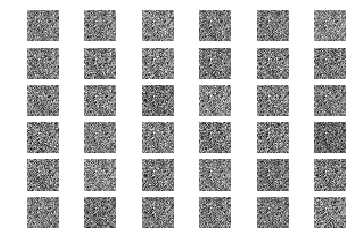

500 [D loss: 0.129979, acc.: 97.66%] [G loss: 4.578722]
1000 [D loss: 0.058832, acc.: 100.00%] [G loss: 4.527555]
1500 [D loss: 0.020519, acc.: 100.00%] [G loss: 6.327163]
2000 [D loss: 0.011867, acc.: 100.00%] [G loss: 9.625917]
2500 [D loss: 0.002852, acc.: 100.00%] [G loss: 11.787610]
3000 [D loss: 0.000481, acc.: 100.00%] [G loss: 15.661345]
3500 [D loss: 0.029221, acc.: 98.44%] [G loss: 12.089450]
4000 [D loss: 0.047609, acc.: 98.44%] [G loss: 10.065426]
4500 [D loss: 0.086365, acc.: 97.66%] [G loss: 10.980916]
5000 [D loss: 0.209884, acc.: 89.06%] [G loss: 10.762047]


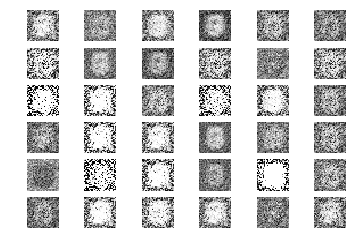

5500 [D loss: 0.337790, acc.: 82.81%] [G loss: 6.169261]
6000 [D loss: 0.461263, acc.: 74.22%] [G loss: 2.835438]
6500 [D loss: 0.676813, acc.: 56.25%] [G loss: 2.269190]
7000 [D loss: 0.813475, acc.: 46.09%] [G loss: 1.335042]
7500 [D loss: 0.674966, acc.: 50.78%] [G loss: 1.487556]
8000 [D loss: 0.736114, acc.: 46.09%] [G loss: 1.545359]
8500 [D loss: 0.658499, acc.: 57.03%] [G loss: 1.172212]
9000 [D loss: 0.592698, acc.: 69.53%] [G loss: 1.786140]
9500 [D loss: 0.642829, acc.: 56.25%] [G loss: 4.995458]
10000 [D loss: 0.610770, acc.: 63.28%] [G loss: 2.256618]


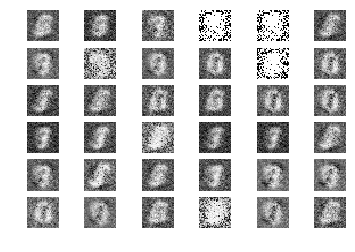

10500 [D loss: 0.724275, acc.: 53.91%] [G loss: 1.595882]
11000 [D loss: 0.580781, acc.: 73.44%] [G loss: 1.280643]
11500 [D loss: 0.599853, acc.: 64.06%] [G loss: 2.440758]
12000 [D loss: 0.555571, acc.: 75.78%] [G loss: 1.887877]
12500 [D loss: 0.546180, acc.: 89.84%] [G loss: 1.573031]
13000 [D loss: 0.815096, acc.: 41.41%] [G loss: 0.868151]
13500 [D loss: 0.549364, acc.: 69.53%] [G loss: 1.878260]
14000 [D loss: 0.675861, acc.: 49.22%] [G loss: 7.161298]
14500 [D loss: 0.690999, acc.: 50.00%] [G loss: 1.344422]
15000 [D loss: 0.649325, acc.: 60.16%] [G loss: 1.391636]


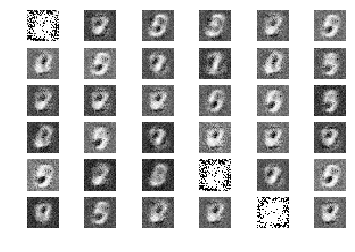

15500 [D loss: 0.588152, acc.: 69.53%] [G loss: 1.880142]
16000 [D loss: 0.581729, acc.: 78.12%] [G loss: 1.913983]
16500 [D loss: 0.625693, acc.: 72.66%] [G loss: 1.364200]
17000 [D loss: 0.571682, acc.: 71.09%] [G loss: 1.593040]
17500 [D loss: 0.631137, acc.: 67.19%] [G loss: 1.252068]
18000 [D loss: 0.572625, acc.: 77.34%] [G loss: 1.293677]
18500 [D loss: 0.629985, acc.: 59.38%] [G loss: 1.923699]
19000 [D loss: 0.692693, acc.: 51.56%] [G loss: 1.376549]
19500 [D loss: 0.564790, acc.: 71.09%] [G loss: 1.262224]
20000 [D loss: 0.521044, acc.: 81.25%] [G loss: 2.601429]


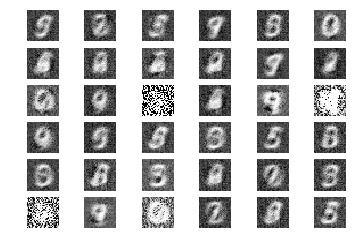

20500 [D loss: 0.547071, acc.: 77.34%] [G loss: 2.147342]
21000 [D loss: 0.578563, acc.: 70.31%] [G loss: 1.161466]
21500 [D loss: 0.611776, acc.: 74.22%] [G loss: 1.076251]
22000 [D loss: 0.631868, acc.: 67.19%] [G loss: 1.522457]
22500 [D loss: 0.597533, acc.: 64.84%] [G loss: 2.173527]
23000 [D loss: 0.580792, acc.: 68.75%] [G loss: 1.312895]
23500 [D loss: 0.587418, acc.: 73.44%] [G loss: 1.369038]
24000 [D loss: 0.693007, acc.: 53.91%] [G loss: 1.542090]
24500 [D loss: 0.573087, acc.: 71.88%] [G loss: 1.429764]
25000 [D loss: 0.555225, acc.: 75.00%] [G loss: 1.405051]


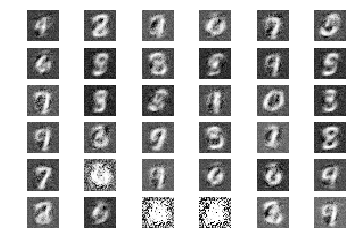

25500 [D loss: 0.593021, acc.: 69.53%] [G loss: 1.464509]
26000 [D loss: 0.797524, acc.: 43.75%] [G loss: 1.777135]
26500 [D loss: 0.623841, acc.: 68.75%] [G loss: 1.616841]
27000 [D loss: 0.583165, acc.: 75.00%] [G loss: 1.285352]
27500 [D loss: 0.588999, acc.: 70.31%] [G loss: 1.526710]
28000 [D loss: 0.546855, acc.: 68.75%] [G loss: 1.480388]
28500 [D loss: 0.540359, acc.: 72.66%] [G loss: 1.261154]
29000 [D loss: 0.633541, acc.: 64.84%] [G loss: 1.321901]
29500 [D loss: 0.517066, acc.: 77.34%] [G loss: 1.420163]
30000 [D loss: 0.710490, acc.: 51.56%] [G loss: 2.159274]


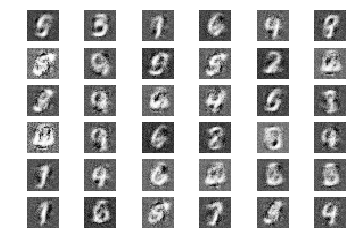

30500 [D loss: 0.602513, acc.: 62.50%] [G loss: 1.713559]
31000 [D loss: 0.601196, acc.: 64.84%] [G loss: 1.639220]
31500 [D loss: 0.601543, acc.: 71.88%] [G loss: 1.007645]
32000 [D loss: 0.510918, acc.: 79.69%] [G loss: 1.393331]
32500 [D loss: 0.607571, acc.: 69.53%] [G loss: 1.085217]
33000 [D loss: 0.532071, acc.: 72.66%] [G loss: 1.421769]
33500 [D loss: 0.547047, acc.: 72.66%] [G loss: 1.745017]
34000 [D loss: 0.528769, acc.: 79.69%] [G loss: 1.188379]
34500 [D loss: 0.517644, acc.: 71.88%] [G loss: 1.667115]
35000 [D loss: 0.533914, acc.: 75.78%] [G loss: 1.575127]


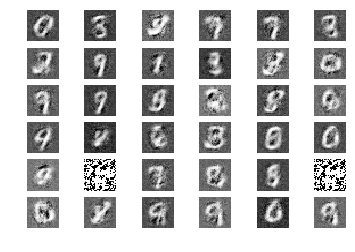

35500 [D loss: 0.449638, acc.: 85.16%] [G loss: 1.249013]
36000 [D loss: 0.472357, acc.: 81.25%] [G loss: 1.486825]
36500 [D loss: 0.505037, acc.: 75.78%] [G loss: 1.502220]
37000 [D loss: 0.596966, acc.: 65.62%] [G loss: 1.873569]
37500 [D loss: 0.561537, acc.: 71.09%] [G loss: 1.332023]
38000 [D loss: 0.436443, acc.: 77.34%] [G loss: 2.005839]
38500 [D loss: 0.491917, acc.: 79.69%] [G loss: 2.184150]
39000 [D loss: 0.528480, acc.: 75.00%] [G loss: 1.723334]
39500 [D loss: 0.465622, acc.: 81.25%] [G loss: 1.659984]
40000 [D loss: 0.484835, acc.: 79.69%] [G loss: 1.628776]


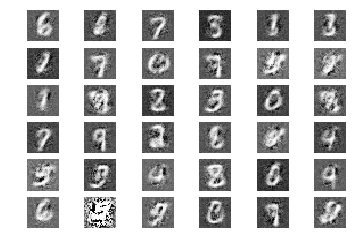

40500 [D loss: 0.554461, acc.: 78.91%] [G loss: 1.450221]
41000 [D loss: 0.475504, acc.: 81.25%] [G loss: 2.073874]
41500 [D loss: 0.528650, acc.: 80.47%] [G loss: 1.760107]
42000 [D loss: 0.456527, acc.: 85.16%] [G loss: 1.646296]
42500 [D loss: 0.536312, acc.: 77.34%] [G loss: 1.355574]
43000 [D loss: 0.472181, acc.: 78.91%] [G loss: 1.684752]
43500 [D loss: 0.523378, acc.: 75.78%] [G loss: 1.861510]
44000 [D loss: 0.447336, acc.: 81.25%] [G loss: 1.862054]
44500 [D loss: 0.476010, acc.: 78.12%] [G loss: 1.817659]
45000 [D loss: 0.520735, acc.: 73.44%] [G loss: 1.554803]


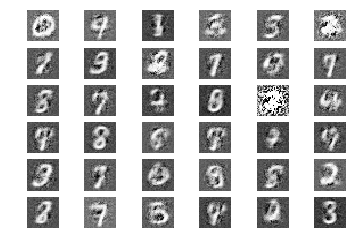

45500 [D loss: 0.444002, acc.: 82.03%] [G loss: 5.550780]
46000 [D loss: 0.461373, acc.: 80.47%] [G loss: 1.647681]
46500 [D loss: 0.396674, acc.: 86.72%] [G loss: 1.707124]
47000 [D loss: 0.391759, acc.: 87.50%] [G loss: 2.576607]
47500 [D loss: 0.437667, acc.: 81.25%] [G loss: 1.837760]
48000 [D loss: 0.388542, acc.: 86.72%] [G loss: 2.004470]
48500 [D loss: 0.467631, acc.: 83.59%] [G loss: 2.632628]
49000 [D loss: 0.515701, acc.: 77.34%] [G loss: 2.042337]
49500 [D loss: 0.377246, acc.: 85.94%] [G loss: 1.929145]


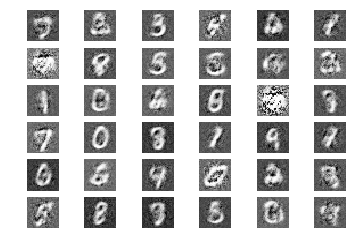

In [11]:
for loop in range(50000):
    # ------------------
    # discriminator 학습
    # ------------------

    # (real_data: 64) + (generated_data: 64) = batch_size(128)
    # 랜덤으로 real_data 64개를 뽑습니다.
    index = np.random.randint(0, X_train.shape[0], 64)
    imgs = X_train[index]

    # 랜덤 노이즈를 64개 만큼 뽑습니다.
    # 64개 만큼의 이미지를 generator 로 생성합니다.
    noise = np.random.uniform(0, 1, (64, 100))
    gen_imgs = generator.predict(noise)

    # discriminator 학습
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((64, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((64, 1)))

    # train_on_batch 의 return 값은 loss 이므로 real 과 fake 의 평균 loss 를 d_loss 에 저장합니다.
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # --------------
    # generator 학습
    # --------------
    # batch size 만큼의 랜덤 노이즈를 생성합니다.
    noise = np.random.uniform(0, 1, (128, 100))

    # generator 는 자신이 만들어 낸 이미지를 discriminator 가 1로 인식하기를 바랍니다.
    valid_y = np.array([1] * 128)

    # 합쳐진 모델(generator 만) 학습
    g_loss = combined.train_on_batch(noise, valid_y)

    # 500번 학습마다 loss 출력
    if loop % 500 == 0:
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (loop, d_loss[0], 100 * d_loss[1], g_loss))

    # 5000번 학습마다 generator 가 생성하는 img 를 보여줍니다.
    if loop % 5000 == 0 or loop == 49999:
        r, c = 6, 6
        noise = np.random.uniform(0, 1, (r * c, 100))
        gen_imgs = generator.predict(noise)

        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)

        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.show()

숫자가 점점 선명해지지만 조금 결과가 아쉽습니다.

이러한 GAN의 불안정한 generation을 보완하고 발전시키기 위해

추가로 아주 많은 GAN 모델들이 나왔습니다!

관심 있으신 분들은 찾아보시길 바랍니다~!

## Contact me
케라스를 사랑하는 개발자 입니다.

질문, 조언, contribtuion 등 소통은 언제나 환영합니다.

Anthony Kim(김동현) : artit.anthony@gmail.com
